In [30]:
#type this into the commandline (make sure you're in the right directory)
#mongoexport --db venmo --collection venmo --type=csv --out notes.csv --fields note
import numpy as np
import pandas as pd
import gensim 
import string
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec
from collections import Counter
from nltk.corpus import stopwords

In [31]:
df = pd.read_csv("notes.csv")

In [32]:
df = df.dropna()

In [33]:
#add more terms?
terms = ['drug','drugs','dealer','marijuana','meth','weed','cocaine','heroin','lsd','coke','shrooms',\
         'liberty caps', 'Alice', 'boomers',' X', 'Superman', 'XTC', 'Adam', 'Beans', 'Love Drug',\
         'Happy Pill', 'Scooby Snacks', 'Smarties', 'Skittles', 'Vitamin E',' H', 'smack', 'tar',\
         'junk', 'black', 'dragon', 'white horse', 'skag', 'snow', 'dust', 'powder', 'nose candy',\
         'coco', 'blow', 'pearl', 'yeyo', 'ice', 'glass', 'rocks', 'crystal', 'crank', 'chalk', 'tweak',\
         'tina', 'Walter white', 'speed']
terms_regex ='|'.join(terms)

In [34]:
#add more emojis?
emojis = ['🚀','🐉','🔌','🥧','💉','💊','🍬','🌨️','🍄','❄','⛄','🔑',\
          '🍚','🤧','🎱','🥥','🍀','🌴','🌳','🌲','😗','💨','😤','💎','🍚',\
         '⚡','🤯']
emojis_regex ='|'.join(emojis)

In [35]:
sus_df = df.loc[df['note'].str.contains(emojis_regex, case = False)]
sus_df

,note
15,🐉
34,💡🔌🔌🔌🔋
59,💦🔌🔥
85,🍚
119,🔌
...,...
7076389,🍪🔌
7076405,💡🔌
7076474,⚡🔌💡💸
7076486,"⚡🔌💡💸 saw it on the counter this morning, being..."


In [36]:
drugs_df = sus_df.loc[sus_df['note'].str.contains(terms_regex, case = False)]
drugs_df

,note
1696,⚡🔌💡💸 Happy PAYDAY 🤦🏽‍♀️
2227,🏈 🌲 🎫 x 2
5406,Drugs💉💊
6135,Electric bill so high from your hotness ⚡🔌💡💸
9637,Ice cold ❄️
...,...
7069547,❄️🎊 thanks but you have too much
7071322,Ice drifting 🏎❄️
7073836,Cocow 🥥😂
7073884,Rum y coco 🌴


In [37]:
corpus = []
for index, row in drugs_df.iterrows():
    note = [word.lower() for word in row["note"].split()]
    corpus.append(note)
model = Word2Vec(corpus, size=100, window=5, min_count=1, workers=4)
#extract feature vector from notes
feature_list = []
for index, row in drugs_df.iterrows():
    note = [word.lower() for word in row["note"].split()]
    for word in note:
        feature = []
        feature.append(model.wv[word])
    feature_list.append(np.average(feature,axis=0))

In [38]:
#split the notes into clusters (still not sure of optimal cluster count)
kmeans = KMeans(n_clusters=5)
kmeans.fit(feature_list)
pd.options.mode.chained_assignment = None
drugs_df["label"] = kmeans.labels_

In [45]:
Counter(kmeans.labels_)

Counter({1: 1556, 0: 418, 3: 448, 4: 11, 2: 193})

In [47]:
def common_words(cluster_num):
    cluster = []
    stop_words = set(stopwords.words('english'))
    for index, row in drugs_df.iterrows():
        if row["label"] == cluster_num:
            note = [word.lower() for word in row["note"].split()]
            for word in note:
                if word not in stop_words:
                    cluster.append(word)
    print("Cluster " + str(cluster_num) + ":")
    print(Counter(cluster).most_common(10))

In [48]:
for i in range(5):
    common_words(i)

Cluster 0:
[('🍚', 65), ('❄️', 56), ('💊', 43), ('rice', 43), ('⚡️', 41), ('🌴', 39), ('💦🔌🔥', 37), ('🐉', 35), ('ice', 34), ('half', 27)]
Cluster 1:
[('ice', 64), ('house', 60), ('-', 45), ('💦🔌🔥', 43), ('⚡🔌💡💸', 42), ('get', 42), ('&', 35), ('happy', 33), ('+', 32), ('drugs', 31)]
Cluster 2:
[('rides', 576), ('got', 543), ('🛎💨', 543), ('nomad', 384), ('like', 362), ('🛋', 362), ('there.', 362), ('👑', 362), ('🏠', 362), ('😉', 193)]
Cluster 3:
[('💉', 33), ('⚡', 33), ('😤', 29), ('x2', 28), ('\U0001f965', 28), ('🍄', 27), ('🚀', 25), ('🔌', 24), ('🤧', 23), ('⚡🔌💡💸', 21)]
Cluster 4:
[('thank', 2), ('hotel', 2), ('🌴', 2), ('🏠', 2), ('⚡🔌💡💸', 2), ('-', 2), ('red', 1), ('dragon', 1), ('🐉', 1), ('kyra', 1)]


In [42]:
#this function generates a wordcloud based on the cluster number you give it (0,1,2,etc.)
def create_cluster_cloud(cluster_num):
    # the regex used to detect words is a combination of normal words, ascii art, and emojis
    # 2+ consecutive letters (also include apostrophes), e.x It's
    normal_word = r"(?:\w[\w']+)"
    # 2+ consecutive punctuations, e.x. :)
    ascii_art = r"(?:[{punctuation}][{punctuation}]+)".format(punctuation=string.punctuation)
    # a single character that is not alpha_numeric or other ascii printable
    emoji = r"(?:[^\s])(?<![\w{ascii_printable}])".format(ascii_printable=string.printable)
    regexp = r"{normal_word}|{ascii_art}|{emoji}".format(normal_word=normal_word, ascii_art=ascii_art, emoji=emoji)
    stopwords = set(STOPWORDS)
    cluster = ' '
    for index, row in drugs_df.iterrows():
        if row["label"] == cluster_num:
            note = [word.lower() for word in row["note"].split()]
            for word in note:
                cluster = cluster + word + ' '
    wordcloud = WordCloud(font_path = "Symbola.ttf", width=1000, height=1000, stopwords = stopwords, regexp = regexp).generate(cluster)
    plt.figure(figsize = (10, 10))
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show() 

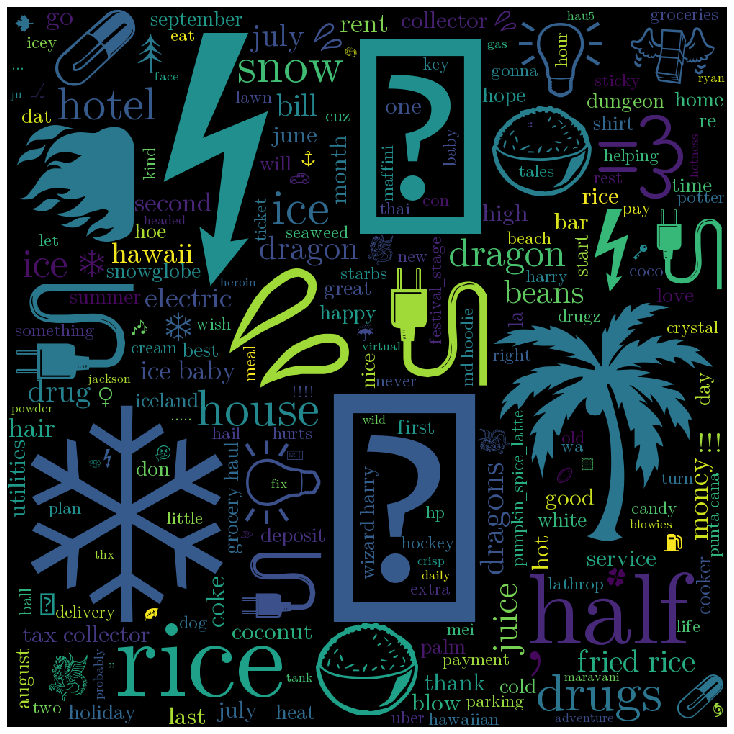

In [43]:
create_cluster_cloud(0)

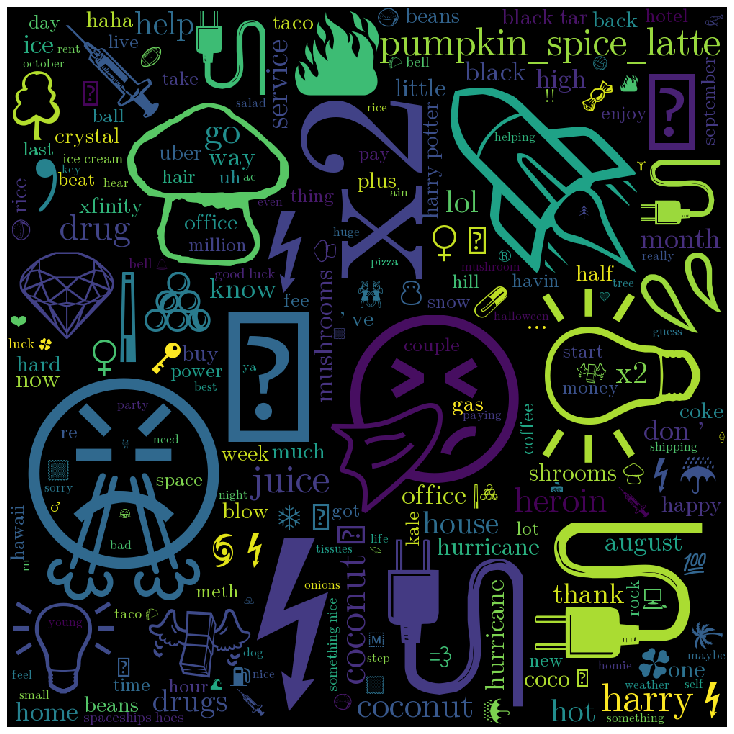

In [44]:
create_cluster_cloud(3)